In [1]:
import copy
import h5py
import itertools
import numpy as np
import os
import scipy
import scipy.interpolate
import tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import palettable

In [3]:
import yt
import trident
import unyt as u

In [4]:
import kalepy as kale
import verdict

In [5]:
import one_zone

# Parameters

In [6]:
# Analysis parameters
seed = 15482
rng = np.random.default_rng( seed )
verbose = False

In [7]:
# Data management parameters
distribution_fp = './data/EAGLE/histogram_galaxies_logM200c-Msun-12.0-12.5_200_seed0_hneutralssh.hdf5'
data_dir = './data/synthetic_data/sample1'
observer_data_dir = './data/synthetic_data_samples/sample1'

In [8]:
# Ray parameters
redshift = 0.25
n_sightlines = 100
min_clouds_per_sightline = 1
max_clouds_per_sightline = 3
velocity_range = [ -150., 150. ] # In km/s
finite_cloud_max_logT = 5 # We'll only allow one cloud per line of sight with temperatures greater than this

In [9]:
# Spectra parameters
ions = [ 'H I', 'O I', 'C II', 'C III', 'N II', 'N III', 'Si II', 'Si III', 'Si IV', 'N V', 'O VI', ]
fields = [
    'H_p0_number_density', 
    'O_p0_number_density',
    'C_p1_number_density',
    'C_p2_number_density',
    'N_p1_number_density',
    'N_p2_number_density',
    'Si_p1_number_density',
    'Si_p2_number_density',
    'Si_p3_number_density',
    'N_p4_number_density',
    'O_p5_number_density',
]
snr = 30

# Load Data

In [10]:
sls = verdict.Dict.from_hdf5( './data/synthetic_data/sample1/sightlines.h5', jagged_flag='sl')

In [11]:
# Objects for use
ldb = trident.LineDatabase('lines.txt')
sg_cos = trident.SpectrumGenerator('COS-G130M')

yt : [INFO     ] 2021-02-24 18:54:43,496 Setting instrument to COS-G130M


In [12]:
# Spectrum Generator for Mg II from ground
lambda_mg = ldb.select_lines( 'Mg', 'II' )[0].wavelength * ( 1. + redshift )
sg_mg = trident.SpectrumGenerator(
    lambda_min = lambda_mg - 15.,
    lambda_max = lambda_mg + 15.,
    dlambda = 0.01,
    lsf_kernel = os.path.join( trident.path, 'data', 'lsf_kernels', 'avg_COS.txt' ),
)

yt : [INFO     ] 2021-02-24 18:54:43,508 Setting instrument to Custom


# Investigate Individual Sightlines for Consistency

We'll take one individual sightline, regenerate it, make sure the regenerated spectra matches with what we gave modelers, and look at why the spectra looks as it does.

In [13]:
i = 4
sg = sg_mg

In [14]:
density = 10.**sls['Density'][i] * u.g * u.cm**-3
temperature = 10.**sls['Temperature'][i] * u.K
metallicity = 10.**sls['Metallicity'][i] * u.Zsun / 0.014
HI_column = 10.**sls['HI Column'][i] * u.cm**-2
velocity = sls['LOS Velocity'][i] * u.km / u.s

In [15]:
lengths_i = []
taus_i = []
for j, density_j in enumerate( density ):

    # First, let's create a one-zone dataset for our desired density,
    # temperature, metallicity, and redshift.  We'll arbitrarily set it to
    # be 1 kpc in width.  
    ds = trident.make_onezone_dataset(
        density = density[j],
        temperature = temperature[j],
        metallicity = metallicity[j],
        domain_width = 1.*u.kpc
    )
    ds.current_redshift = redshift

    # Now let's add our desired ions to this dataset, using Trident's 
    # lookup table based on the Haardt-Madau 2012 UV background.
    trident.add_ion_fields(ds, ions=ions)

    # Since we now know the HI number density for this dataset, and we
    # have a desired HI column density from the simulation distribution, we can divide 
    # these two to get a desired length for the dataset.
    length = HI_column[j] / ds.r[('gas', 'H_p0_number_density')][0]
    lengths_i.append( length )

    if verbose:
        print("DEBUG: For a log HI column of %s, we require a Pathlength of %s" % 
                (np.log10(HI_column[i]), length.to('kpc')))

    if verbose:
        # Print out the dataset to STDOUT
        one_zone.print_dataset(ray, ions, fields)

    # Correct the redshift
    z_vel = np.sqrt( ( 1 + velocity[j] / u.c) / ( 1 - velocity[j] / u.c) ) - 1.
    z_cloud = ( 1. + redshift )*( 1. + z_vel ) - 1.

    # Now that we have a length for our dataset, which will produce our 
    # desired HI column density, let's generate a one-zone
    # LightRay (skewer) using this length, density, temperature, & redshift.
    # And add the relevant ions to this dataset.
    ray = trident.make_onezone_ray(
        density = density[j],
        temperature = temperature[j],
        metallicity = metallicity[j],
        length = length,
        redshift = z_cloud,
    )
    trident.add_ion_fields(ray, ions=ions)

    spectrum_fp = './debug/sl_{}_{}.h5'.format( i, j )
    sg.make_spectrum( ray, lines=ions )
    sg.save_spectrum( spectrum_fp )
    sg.plot_spectrum( './debug/spectrum_{}_{}.png'.format( i, j ))

    d = verdict.Dict.from_hdf5( spectrum_fp )
    wavelength = d['wavelength']
    taus_i.append( d['tau'] )

lengths_i = np.array( lengths_i )
taus_i = np.array( taus_i )

# Combine into a new spectrum
tau_i = np.sum( taus_i, axis=0 )
flux_i = np.exp( -tau_i )
sg.load_spectrum( wavelength * u.Angstrom, tau_i, flux_i )

yt : [INFO     ] 2021-02-24 18:54:43,594 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-02-24 18:54:43,595 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-02-24 18:54:43,595 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-02-24 18:54:43,596 Parameters: domain_right_edge         = [3.08567758e+21 3.08567758e+21 3.08567758e+21]
yt : [INFO     ] 2021-02-24 18:54:43,596 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-02-24 18:54:44,456 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-02-24 18:54:44,535 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-02-24 18:54:44,535 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-02-24 18:54:44,536 Parameters: domain_left_edge          = [0. 0. 0.] cm
yt : [INFO     ] 2021-02-24 18:54:44,537 Parameters: domain_right_edge         = [3.54326405e+23 3.54326405e+23 3.54326405e+23] cm
yt : [INFO     ] 2021-02-24 18:54:44,53

In [16]:
# Noise
sg.apply_lsf()
sg.add_gaussian_noise( snr )

# Save
sg.save_spectrum(
    './debug/spectrum_sl{:04d}.h5'.format( i )
)
sg.plot_spectrum(
    './debug/spectrum_sl{:04d}.png'.format( i )
)

yt : [INFO     ] 2021-02-24 18:54:48,152 Applying default line spread function for Custom.
yt : [INFO     ] 2021-02-24 18:54:48,546 Writing spectrum to hdf5 file: ./debug/spectrum_sl0004.h5.
yt : [INFO     ] 2021-02-24 18:54:48,562 Writing spectrum plot to png file: ./debug/spectrum_sl0004.png


In [17]:
import matplotlib.image as mpimg

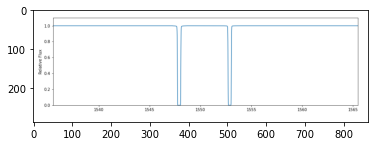

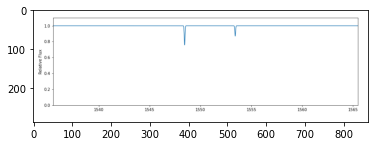

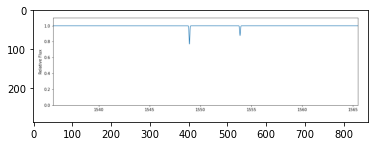

In [18]:
# Constituent spectra
for j, density_j in enumerate( density ):
    plt.imshow( mpimg.imread( './debug/spectrum_{}_{}.png'.format( i, j ) ) )
    plt.show()

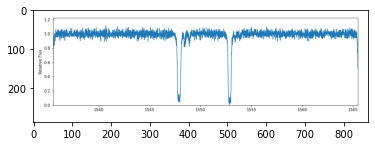

In [19]:
# Final spectra most recently produced
plt.imshow( mpimg.imread( './debug/spectrum_sl{:04d}.png'.format( i ) ) )

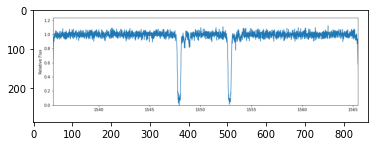

In [20]:
# Spectra given to observers
plt.imshow( mpimg.imread( './debug/spectrum_MgII_sl{:04d}.png'.format( i ) ) )

Looks good! Now why is it so intense?

In [21]:
j = 0

In [22]:
( density[j] / u.mp ).to( 'cm**-3' ), temperature[j], metallicity[j]

(unyt_quantity(0.00011185, 'cm**(-3)'),
 unyt_quantity(142130.26015636, 'K'),
 unyt_quantity(52.72293522, 'Zsun'))

Woah! Look at that metallicity! Let's compare it to the simulation metallicity distribution.

In [23]:
ii = copy.copy( i )
jj = copy.copy( j )

In [24]:
f = h5py.File( distribution_fp, 'r' )
param_labels = [ 'Temperature', 'Density', 'Metallicity', 'HI Column' ]

In [25]:
# Get centers, reformat edges

histogram_axes = [ 'Temperature', 'Density', 'Metallicity', 'hneutralssh' ]
centers = []
bins = []
dxs = []
for i, key in enumerate( histogram_axes ):
    
    arr = copy.copy( f['histogram_axes'][key][...] )
    dx = arr[2] - arr[1]
    
    # For convenience, let's not have a -inf edge lying around
    if key == 'Metallicity':
        arr[0] = arr[1] - dx
        
    centers_i = arr[:-1] + 0.5 * dx
    
    dxs.append( dx )
    centers.append( centers_i )
    bins.append( arr )

In [26]:
# Normalize into a pdf

norm = f['histogram'][...].sum() * dxs[0] * dxs[1] * dxs[2] * dxs[3]
pdf = f['histogram'][...] / norm

In [27]:
# Set up combinations to iterate through
inds = range( len( histogram_axes ) )
combinations = [ _ for _ in itertools.combinations( inds, 2 ) ]

<ipython-input-28-c80981e2a19f>:16: RuntimeWarning: divide by zero encountered in log10
  np.log10( projection ),


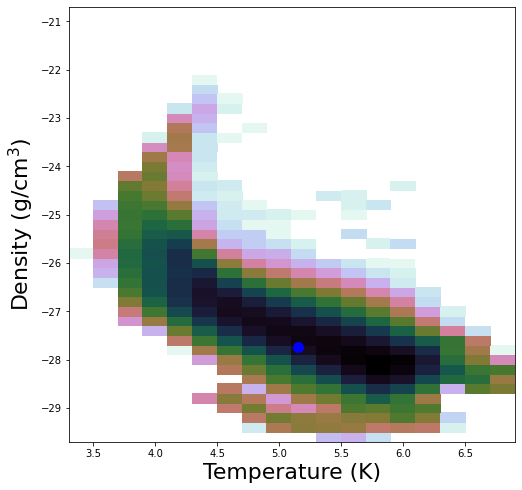

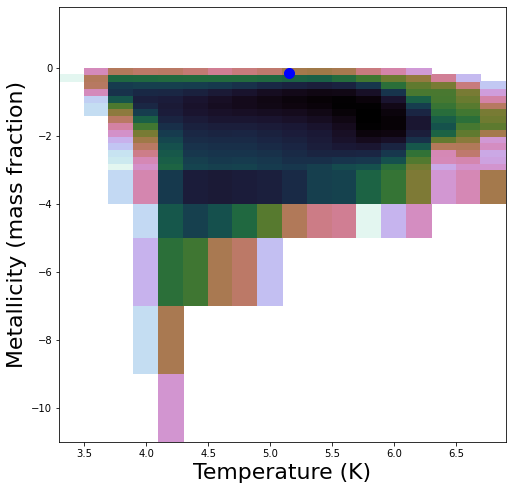

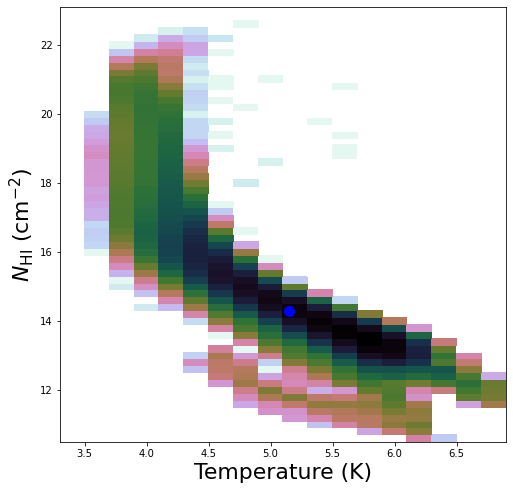

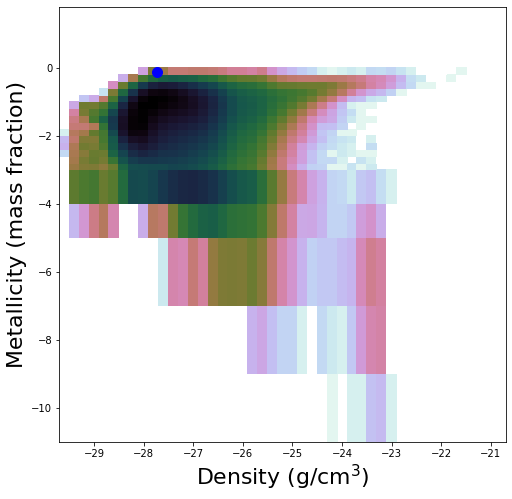

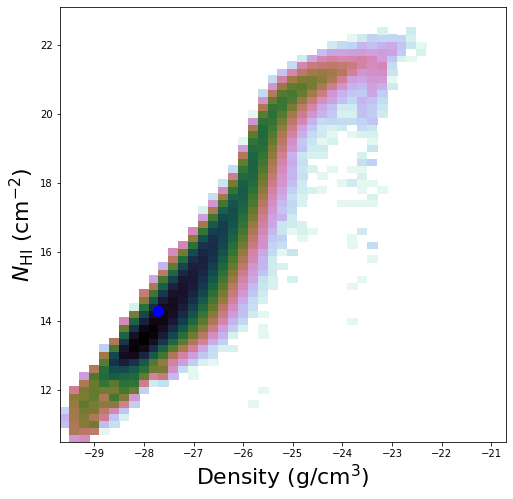

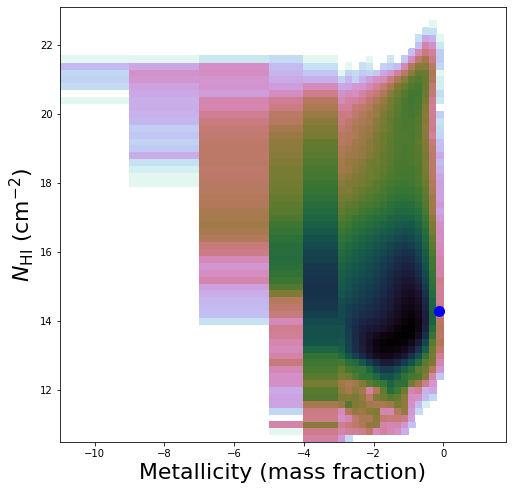

In [28]:
labels = [ 'Temperature (K)', r'Density (g/cm$^{3}$)', 'Metallicity (mass fraction)', r'$N_{\rm HI}$ (cm$^{-2}$)' ]
for k, (i, j) in enumerate( combinations ):
    
    # Show data
    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    sum_axes = copy.copy( list( inds ) )
    sum_axes.remove( i )
    sum_axes.remove( j )
    projection = pdf.sum( axis=tuple( sum_axes ) ).transpose()
    x, y = np.meshgrid( centers[i], centers[j] )
    ax.pcolormesh(
        centers[i],
        centers[j],
        np.log10( projection ),
        cmap = 'cubehelix_r',
    )
    
    ax.scatter(
        sls[param_labels[i]][ii][jj],
        sls[param_labels[j]][ii][jj],
        color = 'blue',
        s = 100,
    )

    
    ax.set_xlabel( labels[i], fontsize=22 )
    ax.set_ylabel( labels[j], fontsize=22 )
    
    ax.set_aspect( 'auto' )
    
    plt.savefig(
        './figures/sample1/clouddist_{}_{}.png'.format(
            param_labels[i].replace( ' ', '' ),
            param_labels[j].replace( ' ', '' )
        ),
        bbox_inches = 'tight',
    )

Consistent with the metallicity distribution. Asking Nastasha how such enriched gas is produced in the EAGLE sims.

# Some Listed Lines are Actually Outside Observable Range

In [29]:
suspect_ions =  [ 'Si III', 'Si IV', 'N V' ]

In [30]:
def print_observable_redshifts( ion_list ):

    for ion in ion_list:

        print( ion )

        lines = ldb.select_lines( *ion.split( ' ' ) )

        for i, line in enumerate( lines ):
            lambda_rest = line.wavelength * u.angstrom
            min_z = sg_cos.lambda_min / lambda_rest  - 1.
            max_z = sg_cos.lambda_max / lambda_rest  - 1.

            print( '    {} observable redshifts = [{:.2g}, {:.2g}]'.format( lambda_rest, min_z, max_z ) )

In [31]:
print_observable_redshifts( suspect_ions )

Si III
    1206.5 Å observable redshifts = [-0.047 dimensionless, 0.2 dimensionless]
Si IV
    1402.77 Å observable redshifts = [-0.18 dimensionless, 0.034 dimensionless]
N V
    1242.804 Å observable redshifts = [-0.075 dimensionless, 0.17 dimensionless]
    1238.821 Å observable redshifts = [-0.072 dimensionless, 0.17 dimensionless]


In [32]:
print_observable_redshifts( ions )

H I
    1215.67 Å observable redshifts = [-0.054 dimensionless, 0.19 dimensionless]
    1025.7222 Å observable redshifts = [0.12 dimensionless, 0.41 dimensionless]
    972.53674 Å observable redshifts = [0.18 dimensionless, 0.49 dimensionless]
    949.74298 Å observable redshifts = [0.21 dimensionless, 0.53 dimensionless]
    937.8034 Å observable redshifts = [0.23 dimensionless, 0.55 dimensionless]
    930.7482 Å observable redshifts = [0.24 dimensionless, 0.56 dimensionless]
    926.22564 Å observable redshifts = [0.24 dimensionless, 0.57 dimensionless]
    923.1503 Å observable redshifts = [0.25 dimensionless, 0.57 dimensionless]
    920.963026 Å observable redshifts = [0.25 dimensionless, 0.57 dimensionless]
    919.351351 Å observable redshifts = [0.25 dimensionless, 0.58 dimensionless]
    918.129312 Å observable redshifts = [0.25 dimensionless, 0.58 dimensionless]
    917.180525 Å observable redshifts = [0.25 dimensionless, 0.58 dimensionless]
    916.429085 Å observable redshif